In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.stats.multicomp import multipletests

# Задание 6
Требуется подобрать и применить наилучший статистический метод, позволяющий ответить на вопрос прикладной задачи; обосновать выбор метода, его применимость и оптимальность. Не нужно использовать все возможные методы, нужно выбрать наиболее подходящий. Помимо выводов, касающихся математических особенностей решения, необходимо в терминах предметной области сформулировать выводы, которые могли бы быть понятны гипотетическому заказчику-нематематику.

Необходимо сдать: ipython notebook и сгенерированный по нему pdf-файл с подробным отчётом по проведённому исследованию, содержащий визуализацию исходных данных, описания и выводы каждого этапа анализа — используемые методы, обоснование их применимости, графики.

По каждой разновидности регрессии в слайдах есть список требований в отчёту.

## Просрочка платежей по кредитам
Для 30000 клиентов тайваньского банка известны сумма кредита, демографические показатели и история платежей по кредитам за последние пять месяцев (факт просрочки, сумма неоходимой выплаты, сумма платежа) (default.xls).

Построить модель, предсказывающую вероятность просрочки следующего платежа, оценить вклад факторов.

# Решение
Загружаем выборку:

In [2]:
df = pd.read_excel('default.xls', sheet_name=1, index_col='ID') \
    .rename(columns={'default payment next month': 'default_payment_next_month'})
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

Выведем количество значений у целевой переменной:

In [4]:
df['default_payment_next_month'].value_counts()

0    23364
1     6636
Name: default_payment_next_month, dtype: int64

## Разделимость по вещественным признакам
Построим графики и посмотрим на разделимость целевой переменной.

Для вещественных признаков построим pairplot. Часть однотипных признаков не будем показывать, т.к. места для всех не хватит.

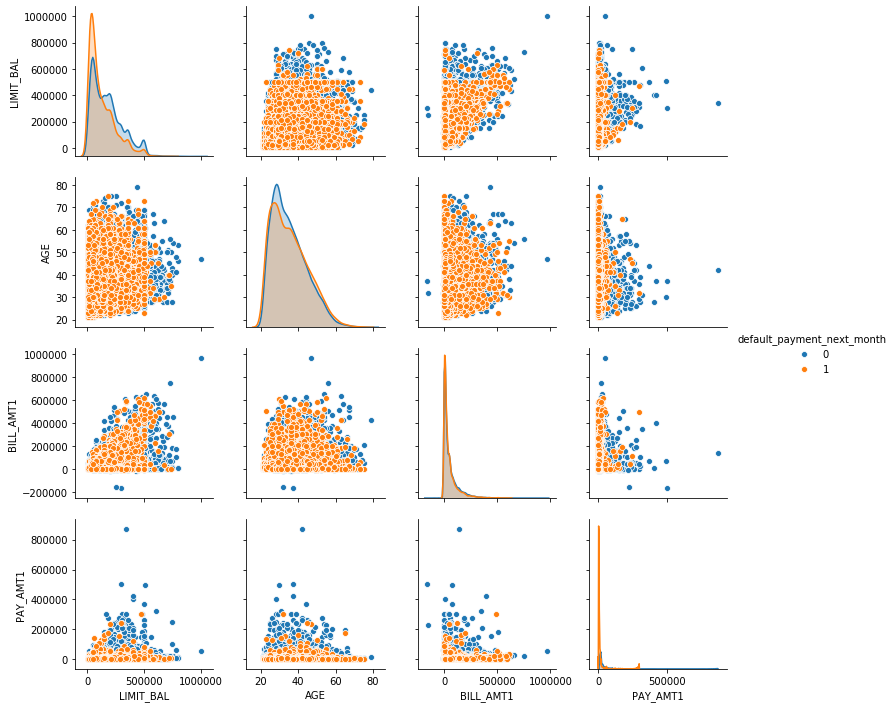

In [5]:
sns.pairplot(df, hue='default_payment_next_month',
             vars=['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1']);

Построим ядерные оценки плотности для тех признаков, что нет на pairplot'e, и убедимся, что целевая переменная по ним не разделяется:

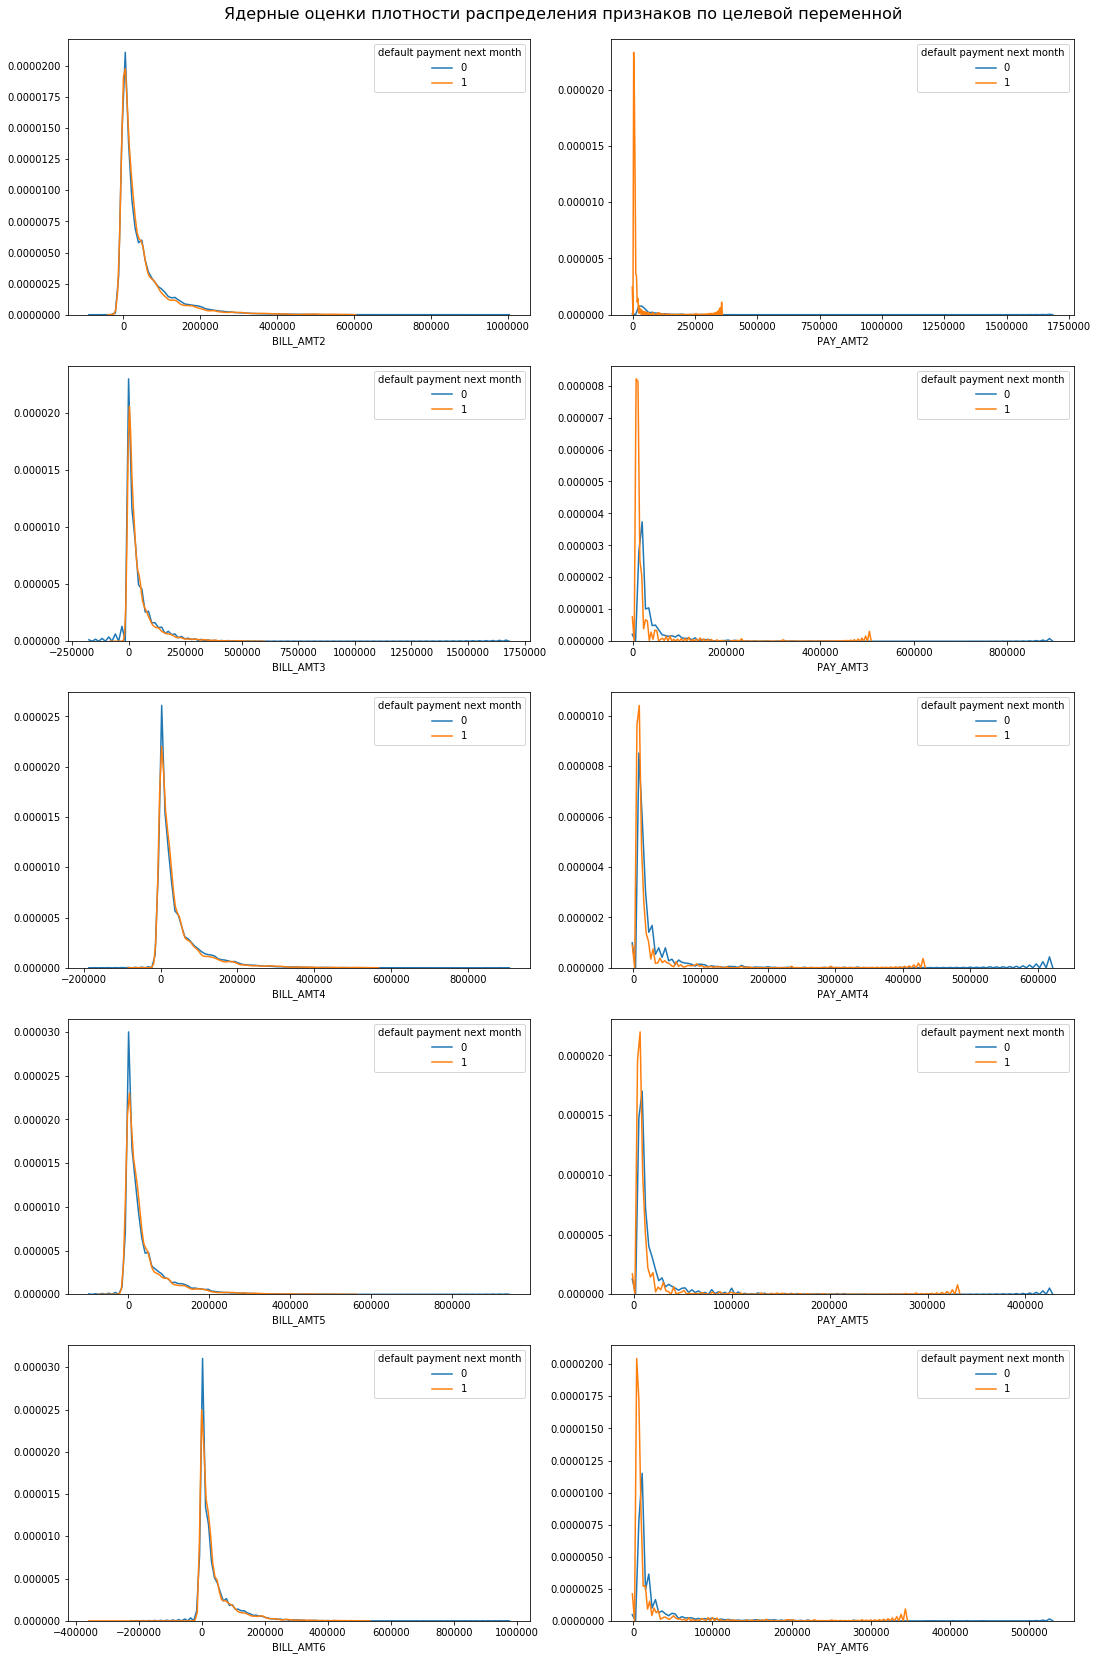

In [6]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 24))
fig.suptitle('Ядерные оценки плотности распределения признаков по целевой переменной', fontsize=16)
fig.tight_layout(h_pad=3, w_pad=5, rect=[0.01, 0.03, 0.99, 0.97])

columns = ['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
           'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for i in range(len(columns)):
    for j in range(2):
        sns.distplot(df[df['default_payment_next_month'] == j][columns[i]],
                     hist=False, label=j, ax=axs[i % 5, i // 5])
        axs[i % 5, i // 5].legend(title='default payment next month')

По оценкам плотности видно, что у признаков `BILL_AMT1` - `BILL_AMT6`, `PAY_ATM1` - `PAY_ATM6` тяжелые правые хвосты.

Целевая переменная не разделяется по вещественным признакам. Судя по pairplot'у, признаки `LIMIT_BAL` и `PAY_ATM1` являются хорошими предикторами целевого значения.

## Разделимость по вещественным признакам
Построим confusion matrix для каждого категориального признака и целевой переменной.

In [7]:
def compute_cramers_v(conf_matrix):
    chi2 = sps.chi2_contingency(conf_matrix, correction=False)[0]
    n = conf_matrix.sum().sum()
    k1, k2 = conf_matrix.shape
    return np.sqrt(chi2 / (n * (min(k1, k2) - 1)))

In [8]:
cat_columns = ['SEX', 'EDUCATION', 'MARRIAGE',
               'PAY_0', 'PAY_2', 'PAY_3',
               'PAY_4', 'PAY_5', 'PAY_6']


for column in cat_columns:
    conf_matrix = pd.crosstab(df[column], df['default_payment_next_month'])
    cramers_v = compute_cramers_v(conf_matrix)
        
    print('{} has Cramer\'s-V = {:.2}'.format(column, cramers_v))
    print(conf_matrix)
    print()
    print()

SEX has Cramer's-V = 0.04
default_payment_next_month      0     1
SEX                                    
1                            9015  2873
2                           14349  3763


EDUCATION has Cramer's-V = 0.074
default_payment_next_month      0     1
EDUCATION                              
0                              14     0
1                            8549  2036
2                           10700  3330
3                            3680  1237
4                             116     7
5                             262    18
6                              43     8


MARRIAGE has Cramer's-V = 0.034
default_payment_next_month      0     1
MARRIAGE                               
0                              49     5
1                           10453  3206
2                           12623  3341
3                             239    84


PAY_0 has Cramer's-V = 0.42
default_payment_next_month      0     1
PAY_0                                  
-2                           2394  

Видно, что нет разделимости целевой переменной по категориальным признакам.

В описании датасета нет информации о том, что значит **0** и **-2** для признаков `PAY_0` - `PAY_6`. У признаков `PAY-5` и `PAY-6` нет значения **1**, что достаточно странно. Нашел дополненное описание признаков на [kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608). Из-за значений **-2**, **-1** на которых нельзя задать порядок, будем рассматривать их как категориальные, а не как порядковые.

У категориальных признаков `PAY_0` - `PAY_6` значения от **3** до **8** встречаются редко, объединим их в одну категорию (по смыслу получается задержка платежа на 3 месяца или более).
В признаках `PAY_2` - `PAY_6` почти нет объектов со значением **1**, объединим их с **2**

Аналогично поступим с признаками `EDUCATION` и `MARRIAGE`. Объединим небольшие категории без описания в `EDUCATION` в одно значение **4** - другое. В `MARRIAGE` объединим разведенных **0** и другое **3**.

In [9]:
for column in cat_columns:
    if 'PAY_' in column:
        df[column] = df[column].apply(lambda x: 4 if x >= 4 else x)
        if column !='PAY_0':
            df[column] = df[column].apply(lambda x: 2 if x == 1 else x)
            
df['EDUCATION'] = df['EDUCATION'].apply(lambda x: 4 if x == 0 or x >= 4 else x)
df['MARRIAGE'] = df['MARRIAGE'].apply(lambda x: 3 if x == 0 else x)

Так как целевая переменная бинарная и нам нужно предсказывать **вероятность** просрочки следующего платежа, то будем строить логистическую регрессию.

Сначала сделаем dummy кодирование категориальных признаков:

In [10]:
data = pd.get_dummies(df, columns=cat_columns, drop_first=True)
# Заменим знак минуса в названии признака, чтобы дальше не было проблем с формулами
data.rename(columns={column: column.replace('-', 'minus_')
                     for column in data.columns}, inplace=True)

Для предварительного отбора признаков построим одномерные модели по каждому фактору, оценим их значимость и сделаем поправку на множественную проверку гипотез:

In [11]:
train_columns = [column for column in data.columns if column != 'default_payment_next_month']

one_dim_models_res = []

for feature in train_columns:
    print(f'{feature}:')
    
    model = smf.logit(f'default_payment_next_month ~ {feature}', data).fit()
    one_dim_models_res.append({
        'feature': feature,
        'AIC': model.aic,
        'LLR': model.llr_pvalue,
        'LLR_pval': model.llr_pvalue
    })

    
one_dim_models_res = pd.DataFrame(one_dim_models_res).set_index('feature')

one_dim_models_res['corrected_LLR_pval'] = multipletests(
    one_dim_models_res['LLR_pval'].values, method='holm')[1]

LIMIT_BAL:
Optimization terminated successfully.
         Current function value: 0.515521
         Iterations 6
AGE:
Optimization terminated successfully.
         Current function value: 0.528327
         Iterations 5
BILL_AMT1:
Optimization terminated successfully.
         Current function value: 0.528225
         Iterations 5
BILL_AMT2:
Optimization terminated successfully.
         Current function value: 0.528320
         Iterations 5
BILL_AMT3:
Optimization terminated successfully.
         Current function value: 0.528321
         Iterations 5
BILL_AMT4:
Optimization terminated successfully.
         Current function value: 0.528370
         Iterations 5
BILL_AMT5:
Optimization terminated successfully.
         Current function value: 0.528400
         Iterations 5
BILL_AMT6:
Optimization terminated successfully.
         Current function value: 0.528408
         Iterations 5
PAY_AMT1:
Optimization terminated successfully.
         Current function value: 0.522581
         Ite

Признаки, значимость которых не отвергается:

In [12]:
one_dim_models_res[one_dim_models_res['corrected_LLR_pval'] < 0.05]

,AIC,LLR,LLR_pval,corrected_LLR_pval
feature,,,,
LIMIT_BAL,30935.287688,2.347333e-170,2.347333e-170,1.032827e-168
BILL_AMT1,31697.488295,5.716961e-04,5.716961e-04,4.573569e-03
PAY_AMT1,31358.867770,3.320497e-78,3.320497e-78,1.328199e-76
PAY_AMT2,31388.127542,7.828895e-72,7.828895e-72,3.053269e-70
PAY_AMT3,31527.769189,2.184473e-41,2.184473e-41,6.990315e-40
PAY_AMT4,31545.989487,2.082263e-37,2.082263e-37,5.690956e-36
PAY_AMT5,31566.152639,5.310692e-33,5.310692e-33,1.274566e-31
PAY_AMT6,31582.391141,1.892597e-29,1.892597e-29,3.595934e-28
SEX_2,31661.771561,5.273224e-12,5.273224e-12,6.327869e-11


Построим модель со статистически значимыми признаками:

In [13]:
features = one_dim_models_res[one_dim_models_res['corrected_LLR_pval'] < 0.05] \
    .index.to_list()
features.sort()

formula = 'default_payment_next_month ~ ' + ' + '.join(features)
model1 = smf.logit(formula, data).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.434534
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29955
Method:                                   MLE   Df Model:                           44
Date:                        Tue, 07 Jan 2020   Pseudo R-squ.:                  0.1777
Time:                                23:25:27   Log-Likelihood:                -13036.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.0585      0.079    -13.329      0.000      -1.214      -0.903
BILL_AMT1      2.032e-06   3.08e-07      6.602      0.000    1.43e-06    2.64e-06
EDUCATION_2       0.0244      0.037      0.653      0.514      -0.049       0.097
EDUCATION_3      -0.0130      0.049     -0.265      0.791      -0.109       0.083
EDUCATION_4      -1.0869      0.192     -5.651      0.000      -1.464      -0.710
LIMIT_BAL     -1.856e-06   1.73e-07    -10.738      0.000   -2.19e-06   -1.52e-06
MARRIAGE_2       -0.1803      0.032     -5.553      0.000      -0.244      -0.117
PAY_0_0          -0.2512      0.116     -2.159      0.031      -0.479      -0.023
PAY_0_1           0.8084      0.084      9.572      0.000       0.643       0.974
PAY_0_2           2.0322      0.106     19.226      0.000       1.825       2.239
PAY_0_3           2.0623      0.167     12.322      0.000       1.734       2.390
PAY_0_4           1.6284      0.252      6.466      0.000       1.135       2.122
PAY_0_minus_1     0.5028      0.108      4.664      0.000       0.291       0.714
PAY_2_0          -0.0344      0.136     -0.252      0.801      -0.302       0.233
PAY_2_2          -0.0367      0.115     -0.320      0.749      -0.262       0.188
PAY_2_3           0.0014      0.175      0.008      0.994      -0.342       0.344
PAY_2_4          -0.6497      0.286     -2.269      0.023      -1.211      -0.088
PAY_2_minus_1    -0.2281      0.112     -2.033      0.042      -0.448      -0.008
PAY_3_0           0.1062      0.124      0.858      0.391      -0.136       0.349
PAY_3_2           0.4387      0.125      3.496      0.000       0.193       0.685
PAY_3_3           0.4026      0.214      1.879      0.060      -0.017       0.823
PAY_3_4           0.2894      0.327      0.885      0.376      -0.351       0.930
PAY_3_minus_1     0.0126      0.107      0.118      0.906      -0.198       0.223
PAY_4_0          -0.0543      0.121     -0.450      0.653      -0.291       0.182
PAY_4_2           0.2330      0.129      1.802      0.072      -0.020       0.486
PAY_4_3           0.1435      0.238      0.602      0.547      -0.324       0.611
PAY_4_4           0.1561      0.379      0.412      0.681      -0.587       0.899
PAY_4_minus_1    -0.1185      0.108     -1.094      0.274      -0.331       0.094
PAY_5_0           0.0107      0.117      0.091      0.927      -0.219       0.240
PAY_5_2           0.2824      0.131      2.149      0.032       0.025       0.540
PAY_5_3           0.1217      0.239      0.510      0.610      -0.346       0.589
PAY_5_4          -0.3100      0.404     -0.768      0.443      -1.102       0.482
PAY_5_minus_1    -0.0898      0.106     -0.847      0.397      -0.297       0.118
PAY_6_0          -0.3153      0.087     -3.606      0.000      -0.487      -0.144
PAY_6_2           0.0628      0.101      0.619      0.536      -0.136       0.262
PAY_6_3           0.5264      0.228      2.314      0

Критерий отношения правдоподобия считает модель существенно лучше константы: `LLR p-value:	0`.

Не все признаки статистически значимо отличаются от нуля в совместной модели. 

Снова уберем из модели все незначимые признаки:

In [14]:
features = model1.pvalues[1:][model1.pvalues[1:] < 0.05].index
formula = 'default_payment_next_month ~ ' + ' + '.join(features)
model2 = smf.logit(formula, data).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.435757
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29978
Method:                                   MLE   Df Model:                           21
Date:                        Tue, 07 Jan 2020   Pseudo R-squ.:                  0.1754
Time:                                23:25:28   Log-Likelihood:                -13073.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.0459      0.073    -14.402      0.000      -1.188      -0.904
BILL_AMT1        2.1e-06   2.96e-07      7.084      0.000    1.52e-06    2.68e-06
EDUCATION_4      -1.1156      0.191     -5.841      0.000      -1.490      -0.741
LIMIT_BAL     -2.037e-06   1.63e-07    -12.507      0.000   -2.36e-06   -1.72e-06
MARRIAGE_2       -0.1804      0.032     -5.716      0.000      -0.242      -0.119
PAY_0_0          -0.2660      0.071     -3.727      0.000      -0.406      -0.126
PAY_0_1           0.7878      0.072     10.884      0.000       0.646       0.930
PAY_0_2           2.0472      0.081     25.387      0.000       1.889       2.205
PAY_0_3           2.1249      0.150     14.164      0.000       1.831       2.419
PAY_0_4           1.6080      0.230      6.981      0.000       1.157       2.059
PAY_0_minus_1     0.4126      0.082      5.034      0.000       0.252       0.573
PAY_2_4          -0.1780      0.210     -0.846      0.398      -0.590       0.234
PAY_2_minus_1    -0.3311      0.061     -5.449      0.000      -0.450      -0.212
PAY_3_2           0.4607      0.047      9.768      0.000       0.368       0.553
PAY_5_2           0.4839      0.055      8.841      0.000       0.377       0.591
PAY_6_0          -0.2702      0.039     -7.002      0.000      -0.346      -0.195
PAY_6_3           0.5310      0.178      2.982      0.003       0.182       0.880
PAY_AMT1      -9.392e-06   2.09e-06     -4.503      0.000   -1.35e-05    -5.3e-06
PAY_AMT2      -7.736e-06   1.83e-06     -4.225      0.000   -1.13e-05   -4.15e-06
PAY_AMT5      -4.498e-06   1.54e-06     -2.922      0.003   -7.52e-06   -1.48e-06
PAY_AMT6      -3.243e-06    1.3e-06     -2.496      0.013   -5.79e-06   -6.96e-07
SEX_2            -0.1589      0.032     -4.986      0.000      -0.221      -0.096
=================================================================================
"""

Остался один незначимый признак - `PAY_2_4`, уберем и его.

In [15]:
features = model2.pvalues[1:][model2.pvalues[1:] < 0.05].index
formula = 'default_payment_next_month ~ ' + ' + '.join(features)
model3 = smf.logit(formula, data).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.435769
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29979
Method:                                   MLE   Df Model:                           20
Date:                        Tue, 07 Jan 2020   Pseudo R-squ.:                  0.1753
Time:                                23:25:28   Log-Likelihood:                -13073.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.0478      0.073    -14.434      0.000      -1.190      -0.906
BILL_AMT1       2.09e-06   2.96e-07      7.056      0.000    1.51e-06    2.67e-06
EDUCATION_4      -1.1154      0.191     -5.840      0.000      -1.490      -0.741
LIMIT_BAL     -2.031e-06   1.63e-07    -12.485      0.000   -2.35e-06   -1.71e-06
MARRIAGE_2       -0.1801      0.032     -5.708      0.000      -0.242      -0.118
PAY_0_0          -0.2649      0.071     -3.712      0.000      -0.405      -0.125
PAY_0_1           0.7854      0.072     10.859      0.000       0.644       0.927
PAY_0_2           2.0466      0.081     25.381      0.000       1.889       2.205
PAY_0_3           2.1193      0.150     14.141      0.000       1.826       2.413
PAY_0_4           1.5039      0.193      7.772      0.000       1.125       1.883
PAY_0_minus_1     0.4111      0.082      5.016      0.000       0.250       0.572
PAY_2_minus_1    -0.3297      0.061     -5.428      0.000      -0.449      -0.211
PAY_3_2           0.4667      0.047     10.010      0.000       0.375       0.558
PAY_5_2           0.4794      0.054      8.799      0.000       0.373       0.586
PAY_6_0          -0.2702      0.039     -7.000      0.000      -0.346      -0.195
PAY_6_3           0.5099      0.176      2.892      0.004       0.164       0.855
PAY_AMT1        -9.4e-06   2.09e-06     -4.506      0.000   -1.35e-05   -5.31e-06
PAY_AMT2      -7.698e-06   1.83e-06     -4.213      0.000   -1.13e-05   -4.12e-06
PAY_AMT5       -4.48e-06   1.54e-06     -2.912      0.004   -7.49e-06   -1.46e-06
PAY_AMT6      -3.246e-06    1.3e-06     -2.499      0.012   -5.79e-06      -7e-07
SEX_2            -0.1585      0.032     -4.973      0.000      -0.221      -0.096
=================================================================================
"""

Попробуем возвращать в модель удаленные признаки, применяя критерий отношения правдоподобия:

In [16]:
def lr_test(m1, m2):
    statistics = np.abs(2 * (m1.llf - m2.llf))
    df = np.abs(m1.df_model - m2.df_model)
    pvalue = 1.0 - sps.chi2.cdf(statistics, df=df)

    return statistics, pvalue

In [17]:
add_feature_results = []

features_used = model3.model.exog_names
for feature_name in data.columns:
    if feature_name not in features_used + ['default_payment_next_month']:
        formula = model3.model.formula + f'+ {feature_name}'
        new_model = smf.logit(formula, data).fit()
        add_feature_results.append({
            'feature': feature_name,
            'AIC': new_model.aic,
            'LLR': new_model.llr,
            'LLR_pval': new_model.llr_pvalue,
            'lr_test_pval': lr_test(model3, new_model)[1]
        })

add_feature_results = pd.DataFrame(add_feature_results).set_index('feature')

add_feature_results['corrected_lr_test_pval'] = multipletests(
    add_feature_results['lr_test_pval'].values, method='holm')[1]

Optimization terminated successfully.
         Current function value: 0.435707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435491
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435761
  

In [18]:
add_feature_results[add_feature_results['corrected_lr_test_pval'] < 0.05]

,AIC,LLR,LLR_pval,lr_test_pval,corrected_lr_test_pval
feature,,,,,
BILL_AMT2,26176.079917,5573.274327,0.0,0.000179,0.004649
BILL_AMT3,26173.441863,5575.912381,0.0,0.000044,0.001195
PAY_4_minus_1,26168.609081,5580.745163,0.0,0.000004,0.000105
PAY_4_2,26166.629538,5582.724706,0.0,0.000001,0.000039
PAY_5_minus_1,26171.082627,5578.271618,0.0,0.000013,0.000371
PAY_6_minus_1,26172.050029,5577.304215,0.0,0.000021,0.000596


Добавляем признаки по одному, если при этом не появляются незначимые:

In [19]:
add_feature_names = add_feature_results[add_feature_results['corrected_lr_test_pval'] < 0.05] \
    .sort_values('corrected_lr_test_pval').index.to_list()

model4 = model3
for feature in add_feature_names:
    features = model4.pvalues[1:][model4.pvalues[1:] < 0.05].index.to_list() + [feature]
    features.sort()

    formula = 'default_payment_next_month ~ ' + ' + '.join(features)
    new_model4 = smf.logit(formula, data).fit()
    if all(new_model4.pvalues[1:] < 0.05):
        model4 = new_model4

Optimization terminated successfully.
         Current function value: 0.435377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434760
         Iterations 7


In [20]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29976
Method:                                   MLE   Df Model:                           23
Date:                        Tue, 07 Jan 2020   Pseudo R-squ.:                  0.1769
Time:                                23:25:51   Log-Likelihood:                -13049.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.0424      0.073    -14.337      0.000      -1.185      -0.900
BILL_AMT1      2.009e-06   2.98e-07      6.744      0.000    1.43e-06    2.59e-06
EDUCATION_4      -1.1085      0.191     -5.799      0.000      -1.483      -0.734
LIMIT_BAL     -1.948e-06   1.63e-07    -11.936      0.000   -2.27e-06   -1.63e-06
MARRIAGE_2       -0.1797      0.032     -5.688      0.000      -0.242      -0.118
PAY_0_0          -0.2217      0.072     -3.073      0.002      -0.363      -0.080
PAY_0_1           0.8270      0.073     11.290      0.000       0.683       0.971
PAY_0_2           2.0730      0.081     25.438      0.000       1.913       2.233
PAY_0_3           2.1576      0.150     14.348      0.000       1.863       2.452
PAY_0_4           1.5204      0.194      7.850      0.000       1.141       1.900
PAY_0_minus_1     0.5110      0.084      6.048      0.000       0.345       0.677
PAY_2_minus_1    -0.2361      0.064     -3.684      0.000      -0.362      -0.111
PAY_3_2           0.3639      0.051      7.132      0.000       0.264       0.464
PAY_4_2           0.2781      0.061      4.529      0.000       0.158       0.398
PAY_4_minus_1    -0.1364      0.061     -2.245      0.025      -0.255      -0.017
PAY_5_2           0.3124      0.062      4.999      0.000       0.190       0.435
PAY_5_minus_1    -0.1664      0.059     -2.814      0.005      -0.282      -0.051
PAY_6_0          -0.3203      0.040     -8.014      0.000      -0.399      -0.242
PAY_6_3           0.4570      0.176      2.594      0.009       0.112       0.802
PAY_AMT1      -9.694e-06   2.09e-06     -4.645      0.000   -1.38e-05    -5.6e-06
PAY_AMT2      -8.348e-06   1.87e-06     -4.474      0.000    -1.2e-05   -4.69e-06
PAY_AMT5      -4.103e-06   1.52e-06     -2.698      0.007   -7.08e-06   -1.12e-06
PAY_AMT6        -3.1e-06   1.29e-06     -2.401      0.016   -5.63e-06   -5.69e-07
SEX_2            -0.1565      0.032     -4.905      0.000      -0.219      -0.094
=================================================================================
"""

## Межфакторные взаимодействия
Теперь рассмотрим все модели с одним межфакторным взаимодействием:

In [21]:
add_feature_results = []
features_used = model4.model.exog_names

for i, feature_name_1 in enumerate(features_used):
    if feature_name_1 != 'Intercept':
        for j, feature_name_2 in enumerate(features_used):
            if j > i and feature_name_2 != 'Intercept':
                print(feature_name_1, feature_name_2)
                pair_of_new_features = f'{feature_name_1}:{feature_name_2}'

                try:
                    formula = model4.model.formula + f'+ {pair_of_new_features}'

                    new_model = smf.logit(formula, data).fit()
                    add_feature_results.append({
                        'feature': pair_of_new_features,
                        'AIC': new_model.aic,
                        'LLR': new_model.llr,
                        'LLR_pval': new_model.llr_pvalue,
                        'lr_test_pval': lr_test(model4, new_model)[1]
                    })
                    
                except np.linalg.LinAlgError:
                    print('LinAlgError')

add_feature_results = pd.DataFrame(add_feature_results).set_index('feature')

BILL_AMT1 EDUCATION_4
Optimization terminated successfully.
         Current function value: 0.434944
         Iterations 7
BILL_AMT1 LIMIT_BAL
Optimization terminated successfully.
         Current function value: 0.434758
         Iterations 7
BILL_AMT1 MARRIAGE_2
Optimization terminated successfully.
         Current function value: 0.434968
         Iterations 7
BILL_AMT1 PAY_0_0
Optimization terminated successfully.
         Current function value: 0.434969
         Iterations 7
BILL_AMT1 PAY_0_1
Optimization terminated successfully.
         Current function value: 0.434967
         Iterations 7
BILL_AMT1 PAY_0_2
Optimization terminated successfully.
         Current function value: 0.434936
         Iterations 7
BILL_AMT1 PAY_0_3
Optimization terminated successfully.
         Current function value: 0.434940
         Iterations 7
BILL_AMT1 PAY_0_4
Optimization terminated successfully.
         Current function value: 0.434736
         Iterations 7
BILL_AMT1 PAY_0_minus_1
Optimiz

/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.434953
         Iterations 7
EDUCATION_4 PAY_0_3
         Current function value: 0.434936
         Iterations: 35
EDUCATION_4 PAY_0_4


/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.434950
         Iterations 14
EDUCATION_4 PAY_0_minus_1
Optimization terminated successfully.
         Current function value: 0.434955
         Iterations 7
EDUCATION_4 PAY_2_minus_1
Optimization terminated successfully.
         Current function value: 0.434897
         Iterations 8
EDUCATION_4 PAY_3_2
Optimization terminated successfully.
         Current function value: 0.434969
         Iterations 7
EDUCATION_4 PAY_4_2
Optimization terminated successfully.
         Current function value: 0.434963
         Iterations 7
EDUCATION_4 PAY_4_minus_1
Optimization terminated successfully.
         Current function value: 0.434879
         Iterations 9
EDUCATION_4 PAY_5_2
         Current function value: 0.434903
         Iterations: 35
EDUCATION_4 PAY_5_minus_1


/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
LinAlgError
EDUCATION_4 PAY_6_0
Optimization terminated successfully.
         Current function value: 0.434960
         Iterations 7
EDUCATION_4 PAY_6_3
Optimization terminated successfully.
         Current function value: 0.434970
         Iterations 7
LinAlgError
EDUCATION_4 PAY_AMT1
Optimization terminated successfully.
         Current function value: 0.434880
         Iterations 7
EDUCATION_4 PAY_AMT2
Optimization terminated successfully.
         Current function value: 0.434969
         Iterations 8
EDUCATION_4 PAY_AMT5
Optimization terminated successfully.
         Current function value: 0.434945
         Iterations 7
EDUCATION_4 PAY_AMT6
Optimization terminated successfully.
         Current function value: 0.434961
         Iterations 7
EDUCATION_4 SEX_2
Optimization terminated successfully.
         Current function value: 0.434970
         Iterations 7
LIMIT_BAL MARRIAGE_2
Optimization terminated successfully.


Optimization terminated successfully.
         Current function value: 0.434970
         Iterations 7
LinAlgError
PAY_0_1 PAY_0_minus_1
Optimization terminated successfully.
         Current function value: 0.434970
         Iterations 7
LinAlgError
PAY_0_1 PAY_2_minus_1
Optimization terminated successfully.
         Current function value: 0.434962
         Iterations 7
PAY_0_1 PAY_3_2
Optimization terminated successfully.
         Current function value: 0.434864
         Iterations 7
PAY_0_1 PAY_4_2
Optimization terminated successfully.
         Current function value: 0.434887
         Iterations 7
PAY_0_1 PAY_4_minus_1
Optimization terminated successfully.
         Current function value: 0.434818
         Iterations 7
PAY_0_1 PAY_5_2
Optimization terminated successfully.
         Current function value: 0.434934
         Iterations 7
PAY_0_1 PAY_5_minus_1
Optimization terminated successfully.
         Current function value: 0.434850
         Iterations 7
PAY_0_1 PAY_6_0
Optimiza

/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.434967
         Iterations 7
PAY_0_4 PAY_5_minus_1
         Current function value: 0.434913
         Iterations: 35


/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PAY_0_4 PAY_6_0
Optimization terminated successfully.
         Current function value: 0.434967
         Iterations 7
PAY_0_4 PAY_6_3
Optimization terminated successfully.
         Current function value: 0.434906
         Iterations 7
PAY_0_4 PAY_AMT1
Optimization terminated successfully.
         Current function value: 0.434914
         Iterations 7
PAY_0_4 PAY_AMT2
Optimization terminated successfully.
         Current function value: 0.434969
         Iterations 7
PAY_0_4 PAY_AMT5
Optimization terminated successfully.
         Current function value: 0.434812
         Iterations 9
PAY_0_4 PAY_AMT6
Optimization terminated successfully.
         Current function value: 0.434948
         Iterations 7
PAY_0_4 SEX_2
Optimization terminated successfully.
         Current function value: 0.434965
         Iterations 7
PAY_0_minus_1 PAY_2_minus_1
Optimization terminated successfully.
         Current function value: 0.434936
         Iterations 7
PAY_0_minus_1 PAY_3_2
Optimization termina

PAY_5_2 PAY_AMT5
Optimization terminated successfully.
         Current function value: 0.434964
         Iterations 7
PAY_5_2 PAY_AMT6
Optimization terminated successfully.
         Current function value: 0.434969
         Iterations 7
PAY_5_2 SEX_2
Optimization terminated successfully.
         Current function value: 0.434969
         Iterations 7
PAY_5_minus_1 PAY_6_0
Optimization terminated successfully.
         Current function value: 0.434943
         Iterations 7
PAY_5_minus_1 PAY_6_3
Optimization terminated successfully.
         Current function value: 0.434919
         Iterations 7
PAY_5_minus_1 PAY_AMT1
Optimization terminated successfully.
         Current function value: 0.434870
         Iterations 7
PAY_5_minus_1 PAY_AMT2
Optimization terminated successfully.
         Current function value: 0.434923
         Iterations 7
PAY_5_minus_1 PAY_AMT5
Optimization terminated successfully.
         Current function value: 0.434871
         Iterations 7
PAY_5_minus_1 PAY_AMT6


Добавим в модель все взаимодействия с p-value меньше, чем 0.05 

In [22]:
add_feature_results['corrected_lr_test_pval'] = multipletests(
    add_feature_results['lr_test_pval'].values, method='holm')[1]

/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:182: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphaf / np.arange(ntests, 0, -1)
/home/xfs/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:257: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


,AIC,LLR,LLR_pval,lr_test_pval,corrected_lr_test_pval
feature,,,,,
BILL_AMT1:PAY_0_4,26134.140614,5621.213630,0.0,1.790428e-04,3.741994e-02
BILL_AMT1:PAY_0_minus_1,26128.516556,5626.837689,0.0,9.236207e-06,2.031966e-03
BILL_AMT1:PAY_AMT1,26126.777082,5628.577162,0.0,3.722478e-06,8.301126e-04
BILL_AMT1:PAY_AMT2,26134.042644,5621.311600,0.0,1.699557e-04,3.569069e-02
BILL_AMT1:PAY_AMT5,26125.335417,5630.018827,0.0,1.756642e-06,3.934878e-04
BILL_AMT1:PAY_AMT6,26131.875564,5623.478680,0.0,5.394393e-05,1.149006e-02
LIMIT_BAL:PAY_0_0,26080.283286,5675.070958,0.0,2.220446e-16,5.129230e-14
LIMIT_BAL:PAY_0_2,26131.137975,5624.216269,0.0,3.656592e-05,7.861673e-03
LIMIT_BAL:PAY_0_4,26134.192920,5621.161324,0.0,1.840931e-04,3.829137e-02


In [33]:
add_feature_results[add_feature_results['corrected_lr_test_pval'] < 0.05]

,AIC,LLR,LLR_pval,lr_test_pval,corrected_lr_test_pval
feature,,,,,
BILL_AMT1:PAY_0_4,26134.140614,5621.213630,0.0,1.790428e-04,3.741994e-02
BILL_AMT1:PAY_0_minus_1,26128.516556,5626.837689,0.0,9.236207e-06,2.031966e-03
BILL_AMT1:PAY_AMT1,26126.777082,5628.577162,0.0,3.722478e-06,8.301126e-04
BILL_AMT1:PAY_AMT2,26134.042644,5621.311600,0.0,1.699557e-04,3.569069e-02
BILL_AMT1:PAY_AMT5,26125.335417,5630.018827,0.0,1.756642e-06,3.934878e-04
BILL_AMT1:PAY_AMT6,26131.875564,5623.478680,0.0,5.394393e-05,1.149006e-02
LIMIT_BAL:PAY_0_0,26080.283286,5675.070958,0.0,2.220446e-16,5.129230e-14
LIMIT_BAL:PAY_0_2,26131.137975,5624.216269,0.0,3.656592e-05,7.861673e-03
LIMIT_BAL:PAY_0_4,26134.192920,5621.161324,0.0,1.840931e-04,3.829137e-02


In [23]:
features = model4.pvalues[1:][model4.pvalues[1:] < 0.05].index.to_list() + \
    add_feature_results[add_feature_results['corrected_lr_test_pval'] < 0.05].index.to_list()
formula = 'default_payment_next_month ~ ' + ' + '.join(features)
model5 = smf.logit(formula, data).fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 0.429703
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29952
Method:                                   MLE   Df Model:                           47
Date:                        Tue, 07 Jan 2020   Pseudo R-squ.:                  0.1868
Time:                                23:28:37   Log-Likelihood:                -12891.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.2422      0.083    -15.016      0.000      -1.404      -1.080
BILL_AMT1                1.978e-06    3.9e-07      5.067      0.000    1.21e-06    2.74e-06
EDUCATION_4                -1.1269      0.195     -5.794      0.000      -1.508      -0.746
LIMIT_BAL               -9.243e-07   2.19e-07     -4.218      0.000   -1.35e-06   -4.95e-07
MARRIAGE_2                 -0.1792      0.032     -5.638      0.000      -0.241      -0.117
PAY_0_0                     0.0513      0.091      0.564      0.573      -0.127       0.230
PAY_0_1                     0.8998      0.075     11.953      0.000       0.752       1.047
PAY_0_2                     2.1748      0.128     16.957      0.000       1.923       2.426
PAY_0_3                     2.2328      0.154     14.539      0.000       1.932       2.534
PAY_0_4                     1.0156      0.268      3.784      0.000       0.490       1.542
PAY_0_minus_1               0.8319      0.094      8.816      0.000       0.647       1.017
PAY_2_minus_1              -0.4013      0.069     -5.811      0.000      -0.537      -0.266
PAY_3_2                     0.5014      0.077      6.509      0.000       0.350       0.652
PAY_4_2                     0.5167      0.121      4.282      0.000       0.280       0.753
PAY_4_minus_1              -0.1567      0.062     -2.545      0.011      -0.277      -0.036
PAY_5_2                     0.5722      0.112      5.111      0.000       0.353       0.792
PAY_5_minus_1              -0.1674      0.060     -2.806      0.005      -0.284      -0.050
PAY_6_0                    -0.2974      0.061     -4.902      0.000      -0.416      -0.178
PAY_6_3                     0.4582      0.174      2.629      0.009       0.117       0.800
PAY_AMT1                -2.047e-05   3.93e-06     -5.206      0.000   -2.82e-05   -1.28e-05
PAY_AMT2                -5.994e-06   2.43e-06     -2.471      0.013   -1.07e-05   -1.24e-06
PAY_AMT5                -6.329e-06   2.46e-06     -2.573      0.010   -1.11e-05   -1.51e-06
PAY_AMT6                -5.353e-06   1.88e-06     -2.846      0.004   -9.04e-06   -1.67e-06
SEX_2                      -0.1448      0.032     -4.512      0.000      -0.208      -0.082
BILL_AMT1:PAY_0_4        2.324e-06      6e-06      0.387      0.699   -9.44e-06    1.41e-05
BILL_AMT1:PAY_0_minus_1 -7.701e-06    2.1e-06     -3.672      0.000   -1.18e-05   -3.59e-06
BILL_AMT1:PAY_AMT1       3.141e-11   1.08e-11      2.909      0.004    1.02e-11    5.26e-11
BILL_AMT1:PAY_AMT2       1.893e-11   1.14e-11      1.665      0.096   -3.36e-12    4.12e-11
BILL_AMT1:PAY_AMT5       2.835e-11   9.86e-12      2.875      0.004    9.02e-12    4.77e-11
BILL_AMT1:PAY_AMT6       1.536e-11   6.98e-12      2.201      0.028    1.68e-12     2.9e-11
LIMIT_BAL:PAY_0_0       -2.464e-06   3.84e-07     -6.425      0.000   -3.22e-06   -1.71e-06
LIMIT_BAL:PAY_0_2        4.687e-07   5.02

In [24]:
print('model4 AIC:', model4.aic)
print('model5 AIC:', model5.aic)

model4 AIC: 26146.179775808298
model5 AIC: 25878.20591794265


Получилось лучше. Теперь уберем незначимые взаимодействия:

In [25]:
features = model5.pvalues[1:][model5.pvalues[1:] < 0.05].index
formula = 'default_payment_next_month ~ ' + ' + '.join(features)
model6 = smf.logit(formula, data).fit()
model6.summary()

Optimization terminated successfully.
         Current function value: 0.430042
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29964
Method:                                   MLE   Df Model:                           35
Date:                        Tue, 07 Jan 2020   Pseudo R-squ.:                  0.1862
Time:                                23:28:38   Log-Likelihood:                -12901.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.1832      0.052    -22.722      0.000      -1.285      -1.081
BILL_AMT1                2.218e-06   3.55e-07      6.256      0.000    1.52e-06    2.91e-06
EDUCATION_4                -1.1321      0.195     -5.820      0.000      -1.513      -0.751
LIMIT_BAL               -1.064e-06   1.67e-07     -6.366      0.000   -1.39e-06   -7.37e-07
MARRIAGE_2                 -0.1816      0.032     -5.718      0.000      -0.244      -0.119
PAY_0_1                     0.8583      0.056     15.423      0.000       0.749       0.967
PAY_0_2                     2.2523      0.069     32.600      0.000       2.117       2.388
PAY_0_3                     2.1900      0.144     15.251      0.000       1.909       2.471
PAY_0_4                     1.4478      0.187      7.754      0.000       1.082       1.814
PAY_0_minus_1               0.7755      0.079      9.799      0.000       0.620       0.931
PAY_2_minus_1              -0.4012      0.069     -5.839      0.000      -0.536      -0.267
PAY_3_2                     0.5185      0.073      7.064      0.000       0.375       0.662
PAY_4_2                     0.4910      0.100      4.918      0.000       0.295       0.687
PAY_4_minus_1              -0.1634      0.061     -2.668      0.008      -0.283      -0.043
PAY_5_2                     0.5541      0.084      6.569      0.000       0.389       0.719
PAY_5_minus_1              -0.1589      0.059     -2.684      0.007      -0.275      -0.043
PAY_6_0                    -0.3345      0.042     -8.006      0.000      -0.416      -0.253
PAY_6_3                     0.4383      0.174      2.522      0.012       0.098       0.779
PAY_AMT1                -2.033e-05   3.88e-06     -5.236      0.000   -2.79e-05   -1.27e-05
PAY_AMT2                -4.024e-06   1.79e-06     -2.252      0.024   -7.53e-06   -5.21e-07
PAY_AMT5                -8.764e-06   2.24e-06     -3.907      0.000   -1.32e-05   -4.37e-06
PAY_AMT6                 -5.56e-06   1.87e-06     -2.968      0.003   -9.23e-06   -1.89e-06
SEX_2                      -0.1456      0.032     -4.549      0.000      -0.208      -0.083
BILL_AMT1:PAY_0_minus_1 -8.444e-06   2.08e-06     -4.052      0.000   -1.25e-05   -4.36e-06
BILL_AMT1:PAY_AMT1        3.19e-11   1.08e-11      2.966      0.003    1.08e-11     5.3e-11
BILL_AMT1:PAY_AMT5       3.672e-11   9.27e-12      3.959      0.000    1.85e-11    5.49e-11
BILL_AMT1:PAY_AMT6       1.662e-11   6.72e-12      2.471      0.013    3.44e-12    2.98e-11
LIMIT_BAL:PAY_0_0       -2.738e-06   2.86e-07     -9.583      0.000    -3.3e-06   -2.18e-06
PAY_0_0:PAY_2_minus_1       0.8544      0.158      5.408      0.000       0.545       1.164
PAY_0_0:PAY_3_2             0.3250      0.110      2.943      0.003       0.109       0.541
PAY_0_0:PAY_4_2             0.3304      0.112      2.960      0.003       0.112       0.549
PAY_0_2:PAY_3_2            -0.3711      0

Стало еще чуть-чуть лучше :) Больше признаки и их взаимодействия менять не будем.

In [26]:
print('model6 AIC:', model6.aic)

model6 AIC: 25874.52973206329


## Линейность логита
Проверим линейность логита по непрерывным признакам, построив диаграмы рассеяния:

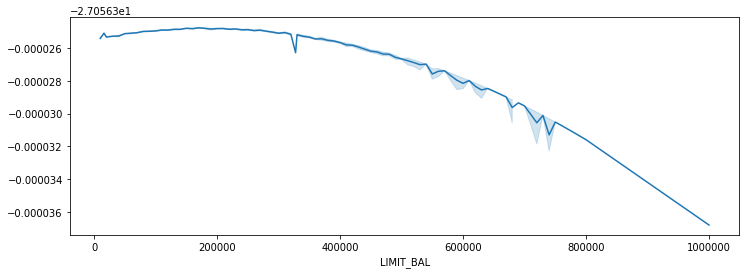

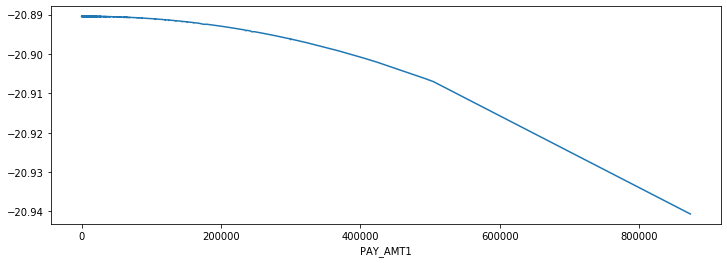

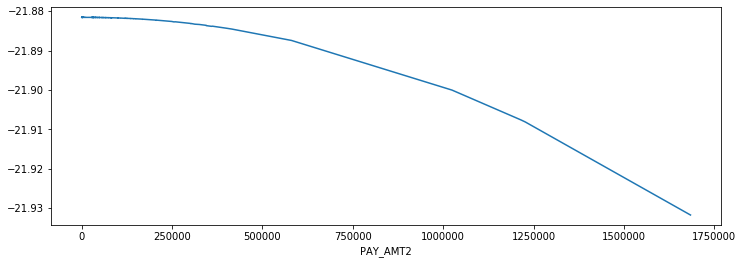

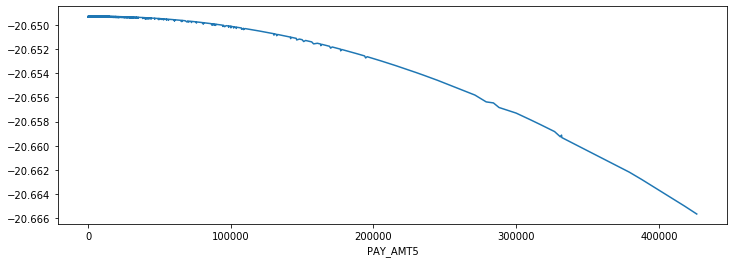

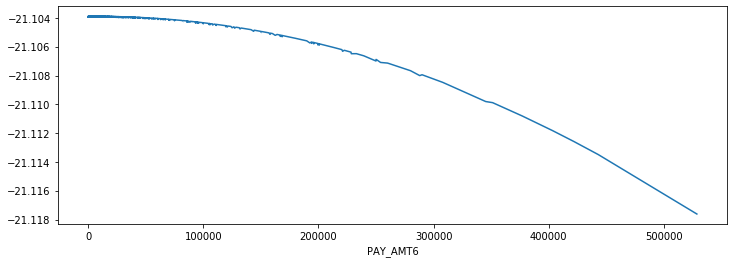

In [27]:
from scipy.stats import gaussian_kde
from scipy.special import logit
from sklearn.neighbors import KernelDensity

for feature_name in ['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT5', 'PAY_AMT6']:
    kde = gaussian_kde([data[feature_name], 1.0 - data.default_payment_next_month], bw_method=0.01 * data[feature_name].std())
    smoothed_labels =  kde([data[feature_name], 1.0 - data.default_payment_next_month])
    smoothed_logits = logit(smoothed_labels)
    plt.figure(figsize=(12, 4))
    sns.lineplot(data[feature_name], smoothed_logits)

На диаграмме рассеяния признака `LIMIT_BAL` можно увидеть квадратичную зависимость, попробуем добавить квадрат признака:

(квадраты остальных вещественных признаки тоже пробовал добавлять, но они делают модель хуже)

In [41]:
quadratic_features = ['I(LIMIT_BAL ** 2)']

features = model6.pvalues[1:][model6.pvalues[1:] < 0.05].index.to_list() + \
    quadratic_features
formula = 'default_payment_next_month ~ ' + ' + '.join(features)
model7 = smf.logit(formula, data).fit()
model7.summary()

Optimization terminated successfully.
         Current function value: 0.429674
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29983
Method:                                   MLE   Df Model:                           16
Date:                        Wed, 08 Jan 2020   Pseudo R-squ.:                  0.1869
Time:                                00:50:09   Log-Likelihood:                -12890.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0737      0.057    -18.885      0.000      -1.185      -0.962
BILL_AMT1                2.449e-06   3.57e-07      6.857      0.000    1.75e-06    3.15e-06
EDUCATION_4                -1.1184      0.194     -5.759      0.000      -1.499      -0.738
LIMIT_BAL               -2.879e-06   4.18e-07     -6.891      0.000    -3.7e-06   -2.06e-06
MARRIAGE_2                 -0.1849      0.032     -5.817      0.000      -0.247      -0.123
PAY_0_1                     0.8629      0.056     15.548      0.000       0.754       0.972
PAY_0_2                     2.2463      0.069     32.588      0.000       2.111       2.381
PAY_0_3                     2.1819      0.144     15.189      0.000       1.900       2.463
PAY_0_4                     1.4292      0.187      7.653      0.000       1.063       1.795
PAY_0_minus_1               0.7885      0.079      9.972      0.000       0.634       0.943
PAY_2_minus_1              -0.3912      0.069     -5.688      0.000      -0.526      -0.256
PAY_3_2                     0.5034      0.074      6.841      0.000       0.359       0.648
PAY_4_2                     0.4779      0.100      4.781      0.000       0.282       0.674
PAY_4_minus_1              -0.1593      0.061     -2.600      0.009      -0.279      -0.039
PAY_5_2                     0.5401      0.084      6.401      0.000       0.375       0.706
PAY_5_minus_1              -0.1567      0.059     -2.646      0.008      -0.273      -0.041
PAY_6_0                    -0.3546      0.042     -8.443      0.000      -0.437      -0.272
PAY_6_3                     0.4056      0.174      2.334      0.020       0.065       0.746
PAY_AMT1                -2.052e-05   3.91e-06     -5.248      0.000   -2.82e-05   -1.29e-05
PAY_AMT2                -4.158e-06   1.79e-06     -2.323      0.020   -7.66e-06    -6.5e-07
PAY_AMT5                -8.179e-06   2.21e-06     -3.704      0.000   -1.25e-05   -3.85e-06
PAY_AMT6                -5.211e-06   1.85e-06     -2.815      0.005   -8.84e-06   -1.58e-06
SEX_2                      -0.1332      0.032     -4.143      0.000      -0.196      -0.070
BILL_AMT1:PAY_0_minus_1  -8.63e-06   2.09e-06     -4.133      0.000   -1.27e-05   -4.54e-06
BILL_AMT1:PAY_AMT1       2.613e-11   1.06e-11      2.459      0.014     5.3e-12     4.7e-11
BILL_AMT1:PAY_AMT5       3.218e-11   9.25e-12      3.477      0.001     1.4e-11    5.03e-11
BILL_AMT1:PAY_AMT6       1.402e-11   6.66e-12      2.105      0.035    9.68e-13    2.71e-11
LIMIT_BAL:PAY_0_0       -2.709e-06    2.8e-07     -9.662      0.000   -3.26e-06   -2.16e-06
PAY_0_0:PAY_2_minus_1       0.8361      0.158      5.286      0.000       0.526       1.146
PAY_0_0:PAY_3_2             0.3224      0.111      2.915      0.004       0.106       0.539
PAY_0_0:PAY_4_2             0.3324      0.112      2.973      0.003       0.113       0.552
PAY_0_2:PAY_3_2            -0.3547      0

Модель стала еще лучше:

In [30]:
print('model6 AIC:', model6.aic)
print('model7 AIC:', model7.aic)

model6 AIC: 25874.52973206329
model7 AIC: 25814.43756818647


## Анализ влиятельных наблюдений

In [45]:
final_data = np.zeros((len(data), len(features)))

for column_idx, feature in enumerate(features):
    splitted_feature = feature.split(':')
    if splitted_feature[0] == 'I(LIMIT_BAL ** 2)':
        final_data[:, column_idx] = data['LIMIT_BAL'].values ** 2
    elif len(splitted_feature) == 1:
        final_data[:, column_idx] = data[splitted_feature[0]].values
    else:
        final_data[:, column_idx] = data[splitted_feature[0]].values * data[splitted_feature[1]].values

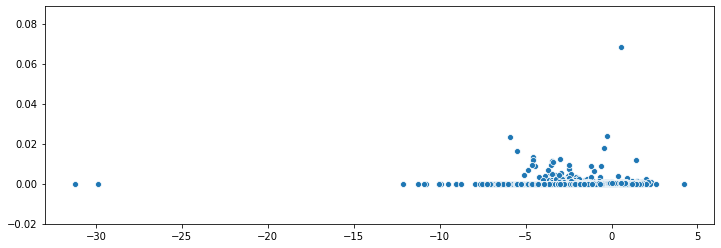

In [49]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

cooks_model = GLM(data['default_payment_next_month'], final_data, family=families.Binomial()).fit()

infl = cooks_model.get_influence()
plt.figure(figsize=(12, 4))
sns.scatterplot(model7.fittedvalues, infl.cooks_distance[0]);

Сделаем фильтрацию по порогу 0.02

In [57]:
filtered_data = data[infl.cooks_distance[0] < 0.02]
print('Fitting on {} / {} of samples'.format(len(filtered_data), len(final_data)))
model_cooks = smf.logit(model7.model.formula, data=filtered_data).fit()
model_cooks.summary()

Fitting on 29997 / 30000 of samples
Optimization terminated successfully.
         Current function value: 0.429437
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                               
======================================================================================
Dep. Variable:     default_payment_next_month   No. Observations:                29997
Model:                                  Logit   Df Residuals:                    29980
Method:                                   MLE   Df Model:                           16
Date:                        Wed, 08 Jan 2020   Pseudo R-squ.:                  0.1872
Time:                                01:06:16   Log-Likelihood:                -12882.
converged:                               True   LL-Null:                       -15849.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0746      0.057    -18.892      0.000      -1.186      -0.963
BILL_AMT1                2.438e-06   3.74e-07      6.512      0.000     1.7e-06    3.17e-06
EDUCATION_4                -1.1163      0.194     -5.749      0.000      -1.497      -0.736
LIMIT_BAL                -2.88e-06    4.2e-07     -6.860      0.000    -3.7e-06   -2.06e-06
MARRIAGE_2                 -0.1845      0.032     -5.803      0.000      -0.247      -0.122
PAY_0_1                     0.8645      0.056     15.575      0.000       0.756       0.973
PAY_0_2                     2.2446      0.069     32.564      0.000       2.110       2.380
PAY_0_3                     2.1853      0.144     15.214      0.000       1.904       2.467
PAY_0_4                     1.4329      0.187      7.674      0.000       1.067       1.799
PAY_0_minus_1               0.8009      0.079     10.100      0.000       0.645       0.956
PAY_2_minus_1              -0.3895      0.069     -5.663      0.000      -0.524      -0.255
PAY_3_2                     0.4964      0.074      6.748      0.000       0.352       0.641
PAY_4_2                     0.4781      0.100      4.782      0.000       0.282       0.674
PAY_4_minus_1              -0.1590      0.061     -2.592      0.010      -0.279      -0.039
PAY_5_2                     0.5401      0.084      6.400      0.000       0.375       0.705
PAY_5_minus_1              -0.1567      0.059     -2.646      0.008      -0.273      -0.041
PAY_6_0                    -0.3528      0.042     -8.401      0.000      -0.435      -0.271
PAY_6_3                     0.4060      0.174      2.337      0.019       0.065       0.747
PAY_AMT1                -2.021e-05   3.93e-06     -5.145      0.000   -2.79e-05   -1.25e-05
PAY_AMT2                 -4.22e-06   1.79e-06     -2.352      0.019   -7.74e-06   -7.04e-07
PAY_AMT5                -8.049e-06   2.21e-06     -3.649      0.000   -1.24e-05   -3.73e-06
PAY_AMT6                -4.958e-06   1.85e-06     -2.679      0.007   -8.59e-06   -1.33e-06
SEX_2                      -0.1339      0.032     -4.166      0.000      -0.197      -0.071
BILL_AMT1:PAY_0_minus_1 -8.358e-06   2.08e-06     -4.027      0.000   -1.24e-05   -4.29e-06
BILL_AMT1:PAY_AMT1       3.004e-11   1.56e-11      1.928      0.054   -4.92e-13    6.06e-11
BILL_AMT1:PAY_AMT5        3.19e-11   9.26e-12      3.445      0.001    1.38e-11    5.01e-11
BILL_AMT1:PAY_AMT6        1.17e-11    6.9e-12      1.696      0.090   -1.82e-12    2.52e-11
LIMIT_BAL:PAY_0_0       -2.738e-06   2.82e-07     -9.727      0.000   -3.29e-06   -2.19e-06
PAY_0_0:PAY_2_minus_1       0.8325      0.158      5.262      0.000       0.522       1.143
PAY_0_0:PAY_3_2             0.3273      0.111      2.959      0.003       0.111       0.544
PAY_0_0:PAY_4_2             0.3321      0.112      2.970      0.003       0.113       0.551
PAY_0_2:PAY_3_2            -0.3500      0

In [58]:
model_cooks.aic

25797.660359346955

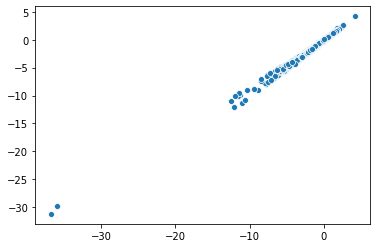

In [59]:
sns.scatterplot(model_cooks.fittedvalues, model7.fittedvalues);

Модель еще немного улучшилась и значительно поменялась.

## Качество классификации

Text(0.5, 0, 'Cutoffs')

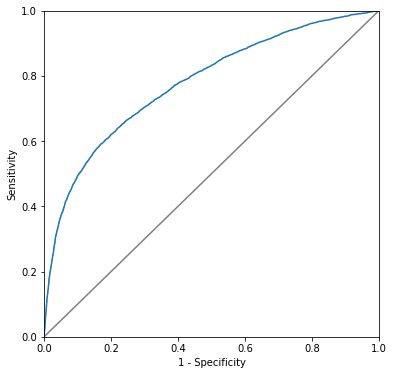

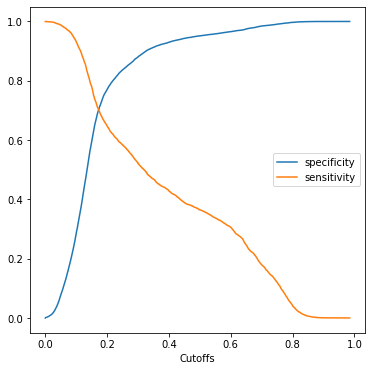

In [60]:
scores = 1.0 / (1.0 + np.exp(-model_cooks.fittedvalues))
sorted_scores = np.sort(scores)

labels = data['default_payment_next_month']
n1 = labels.sum()
n = len(labels)

sensitivity = np.zeros_like(scores)
specificity = np.zeros_like(scores)
for j, u in enumerate(sorted(scores)):
    sensitivity[j] = np.sum((scores >= u) * labels) / float(n1)
    specificity[j] = np.sum((scores <= u) * (1 - labels)) / float(n - n1)

plt.figure(figsize=(6, 6))
sns.lineplot(1 - specificity, sensitivity)
plt.plot([0,1], [0,1], '-', color='grey')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.figure(figsize=(6, 6))
sns.lineplot(np.sort(scores), specificity, label='specificity')
sns.lineplot(np.sort(scores), sensitivity, label='sensitivity')
plt.xlabel('Cutoffs')

По графику выберем порог примерно равный 0.2

In [61]:
idx = np.nonzero(sorted_scores >= 0.2)[0][0]
print('For cutoff {:.4f}: specificity={:.4f}, sensitivity={:.5f}'.format(
    sorted_scores[idx], specificity[idx], sensitivity[idx]
))

For cutoff 0.2000: specificity=0.7708, sensitivity=0.64753


При пороге 0.2 построенная модель обеспечивает чувствительность 0.64753 и специфичность 0.7708

In [63]:
confint_results = np.exp(pd.concat((model_cooks.params, model_cooks.conf_int()), axis=1))
confint_results.columns = ['coef', 'confint_2.5', 'confint_97.5']
confint_results

,coef,confint_2.5,confint_97.5
Intercept,0.341425,0.305405,0.381693
BILL_AMT1,1.000002,1.000002,1.000003
EDUCATION_4,0.327500,0.223843,0.479157
LIMIT_BAL,0.999997,0.999996,0.999998
MARRIAGE_2,0.831547,0.781316,0.885008
PAY_0_1,2.373758,2.129080,2.646553
PAY_0_2,9.436688,8.244173,10.801700
PAY_0_3,8.893370,6.711200,11.785081
PAY_0_4,4.190995,2.906538,6.043081
PAY_0_minus_1,2.227436,1.906837,2.601938


## Выводы:
- люди, не состоящие в браке, пропускают платежы по кредиту на 16.9% реже, доверительный интервал (11.5%, 21.9%);
- отсутствие платежей за прошлый месяц повышает вероятность просрочки следующего платежа по кредиту в 2.37 раза, доверительный интервал (2.13, 2.65);
- отсутствие платежей за прошлые два месяца повышает вероятность просрочки следующего платежа по кредиту в 9.44 раза, доверительный интервал (8.24, 10.80);
- отсутствие задолжности полгода назад снижает вероятность просрочки следующего платежа по кредиту на 29.7%, доверительный интервал (23.9%, 35.3%);
- наличие двух пропущенных платежей пять месяцев назад повышает вероятность просрочки следующего платежа по кредиту на 71.6%, доверительный интервал (45.5%, 102.5%);
- женщины пропускают следующий платеж по кредиту на 12.5% чаще, доверительный интервал (6.8%, 17.9%);
- другое образование, отличающееся от законченных старших классов школы, университа или магистратуры, снижает вероятность просрочки следующего платежа по кредиту на 67.3%, доверительный интервал (52.1%, 77.6%); 🤷‍♂️
- использование возобновляемого кредита в текущем месяце при задержке двух ежемесячных платежей три месяца назад повышает вероятность просрочки следующего платежа по кредиту на 38.7%, доверительный интервал (11.7%, 72.31%).